In [2]:
# Essentials: 
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt


# Sklearn:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Images:
from PIL import Image

# Keras:
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.datasets import fashion_mnist
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Dropout

In [5]:
train_df = pd.read_csv("data/train.csv")
train_df = train_df.drop(["image_phash", "posting_id"], axis=1)
train_df.label_group = train_df.label_group.astype(str)
train_df.head()

,image,title,label_group
0,0000a68812bc7e98c42888dfb1c07da0.jpg,Paper Bag Victoria Secret,249114794
1,00039780dfc94d01db8676fe789ecd05.jpg,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,000a190fdd715a2a36faed16e2c65df7.jpg,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,00117e4fc239b1b641ff08340b429633.jpg,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,00136d1cf4edede0203f32f05f660588.jpg,Nescafe \xc3\x89clair Latte 220ml,3648931069


In [7]:
test_df = pd.read_csv("data/test.csv")
test_df = test_df.drop(["image_phash", "posting_id", "title"], axis=1)
test_df.head()

,image
0,0006c8e5462ae52167402bac1c2e916e.jpg
1,0007585c4d0f932859339129f709bfdc.jpg
2,0008377d3662e83ef44e1881af38b879.jpg


In [8]:
X = train_df.drop("label_group", axis=1)
y = train_df.label_group

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


18637    3829989058
12463    2723899357
30555    2217561812
20772     424835120
12240      66247839
Name: label_group, dtype: object

In [9]:
image_gen = ImageDataGenerator(rotation_range=20, 
                               width_shift_range=0.2, 
                               height_shift_range=0.2, 
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               fill_mode="nearest",
                               rescale=1/255,
                               validation_split=0.25)

In [35]:
train_generator = image_gen.flow_from_dataframe(
    dataframe = train_df,
    directory = "data/train_images/",
    x_col = "image",
    y_col = "label_group",
    subset = "training",
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = "categorical",
    target_size = (32, 32))

valid_generator = image_gen.flow_from_dataframe(
    dataframe = train_df,
    directory = "data/train_images/",
    x_col = "image",
    y_col = "label_group",
    subset = "validation",
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = "categorical",
    target_size = (32, 32))

test_generator=image_gen.flow_from_dataframe(
    dataframe = test_df,
    directory = "data/test_images/",
    x_col = "image",
    batch_size = 1,
    seed = 42,
    shuffle = False,
    class_mode = None,
    target_size = (32, 32))

Found 25688 validated image filenames belonging to 11014 classes.
Found 8562 validated image filenames belonging to 11014 classes.
Found 3 validated image filenames.


In [72]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

vgg_model = VGG16(include_top=False, input_shape=(32, 32, 3))

for layer in vgg_model.layers:
    layer.trainable=False

flat1 = Flatten()(vgg_model.layers[-1].output)
class1 = Dense(256, activation='relu')(flat1)
output = Dense(11014, activation='softmax')(class1)

model = Model(inputs = vgg_model.inputs, outputs = output)

In [75]:
from keras.optimizers import SGD
model.summary()
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss = 'categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

history = model.fit(train_generator,
                    validation_data = valid_generator,
                    epochs=10, verbose=1)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [83]:
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size

STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

STEP_SIZE_TEST = test_generator.n // test_generator.batch_size


In [84]:
IMAGE_SIZE = [32, 32]
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
#here [3] denotes for RGB images(3 channels)

#don't train existing weights
for layer in vgg.layers:
 layer.trainable = False
 
x = Flatten()(vgg.output)
prediction = Dense(11014, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.compile(loss='categorical_crossentropy',
                    optimizer=optimizers.Adam(),
                    metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [85]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

checkpoint = ModelCheckpoint(filepath='mymodel.h5', 
                               verbose=1, save_best_only=True)

callbacks = [checkpoint, lr_reducer]

start = datetime.now()

history = model.fit(train_generator, 
                    steps_per_epoch=STEP_SIZE_TRAIN, 
                    epochs = 18, verbose=5, 
                    validation_data = valid_generator, 
                    validation_steps = STEP_SIZE_VALID)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/18
Epoch 2/18
Epoch 3/18
Epoch 4/18
Epoch 5/18
Epoch 6/18
Epoch 7/18
Epoch 8/18
Epoch 9/18
Epoch 10/18
Epoch 11/18
Epoch 12/18
Epoch 13/18
Epoch 14/18
Epoch 15/18
Epoch 16/18
Epoch 17/18
Epoch 18/18
Training completed in time:  0:35:24.690520


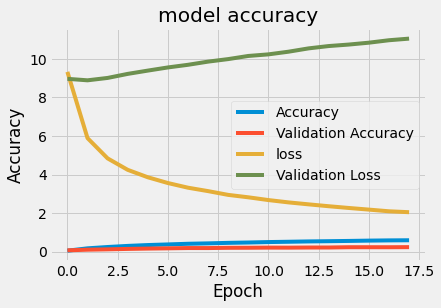

In [87]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy','Validation Accuracy','loss','Validation Loss'])
plt.show()

In [90]:
from keras.models import load_model

model.save('vgg16_model.h5')

In [100]:
#model = load_model('vgg16_model.h5')
history.history['val_accuracy']

[0.0644896999001503,
 0.09702715277671814,
 0.11540262401103973,
 0.13764044642448425,
 0.15507958829402924,
 0.16748595237731934,
 0.1825842708349228,
 0.1815308928489685,
 0.19510768353939056,
 0.19756554067134857,
 0.2048220932483673,
 0.2028324007987976,
 0.20973782241344452,
 0.21044006943702698,
 0.2251872718334198,
 0.22530430555343628,
 0.22460205852985382,
 0.22940075397491455]

In [89]:
#score = model.evaluate(test_set)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

NameError: name 'score' is not defined

In [13]:
IMAGE_SHAPE = (25, 25, 3)
N_CLASSES = 11014

model = keras.Sequential(
    [
        keras.Input(shape=IMAGE_SHAPE),
        
        # embedding layer that does word embedding
        
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Flatten(),
        
        # add concat layer for NLP --> layers.Concatenate(<ARRAY CONTAINING NLP>)
        
        layers.Dropout(0.5), # prevents overfitting
        
        layers.Dense(N_CLASSES, activation="softmax"), # predicts categories, nunique() of y_train
    ]
)

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [57]:
from keras.optimizers import RMSprop
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'

def vgg16():
    model = Sequential()
    #model.add(Reshape((28, 28, 1)))
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=((32, 32, 1)), activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(data_format="channels_last", pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(data_format="channels_last", pool_size=(2, 2)))
    
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(data_format="channels_last", pool_size=(2, 2)))
    
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(data_format="channels_last", pool_size=(2, 2)))

    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    #model.add(MaxPooling2D(data_format="channels_last", pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model


model = vgg16()

In [ ]:
model.fit(train_generator,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_generator,
          validation_steps = STEP_SIZE_VALID,
          epochs = 100,
          callbacks=[stopper],
          workers=4)

In [40]:
stopper = EarlyStopping(monitor="val_loss", patience=2)

In [41]:
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size

STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

STEP_SIZE_TEST = test_generator.n // test_generator.batch_size


In [51]:
model.fit(train_generator,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_generator,
          validation_steps = STEP_SIZE_VALID,
          epochs = 100,
          callbacks=[stopper],
          workers=4)


Epoch 1/100
801/802 [============================>.] - ETA: 0s - loss: 9.3029 - accuracy: 6.4241e-04

KeyboardInterrupt: 